In [1]:
%load_ext autddoreload
%autoreload 2

In [2]:
import sys

sys.path.insert(0, '../')

In [2]:
import torch
from torch.utils.data import DataLoader, Subset

import sys
import json
import pickle
from collections import OrderedDict

from attrdict import AttrDict
from tqdm import tqdm_notebook as tqdm

import numpy as np

import matplotlib as mpl
from matplotlib import colors
import matplotlib.pyplot as plt

from model import RN
from utils import build_dictionaries, collate_samples_from_pixels
from train import initialize_dataset
from viz.IntermediateLayerGetter import IntermediateLayerGetter

In [3]:
with open('config.json', 'r') as f:
    hyp = json.load(f)['hyperparams']['original-fp']

In [4]:
# dictionaries = build_dictionaries('/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/')

In [5]:
with open('viz/CLEVR_built_dictionaries.pkl', 'rb') as f:
    dictionaries = pickle.load(f)

In [6]:
len(dictionaries[0]), len(dictionaries[1])

(82, 28)

In [7]:
args = AttrDict()
args.qdict_size = len(dictionaries[0])
args.adict_size = len(dictionaries[1])

In [8]:
train, val = initialize_dataset(
    clevr_dir='/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/',
    dictionaries=dictionaries,
    state_description=False,
    sub_set=1,
)

==> using cached questions: questions/CLEVR_train_questions.pkl
==> using cached questions: questions/CLEVR_val_questions.pkl


In [9]:
len(train), len(val)

(699989, 149991)

In [10]:
qtypes = np.unique([q['program'][-1]['function'] for q in val.questions])

In [11]:
indexes_per_qtype = {
    qtype: [index for index, q in enumerate(val.questions) if q['program'][-1]['function'] == qtype] for qtype in tqdm(qtypes)
}

In [12]:
[len(idxs) for idxs in indexes_per_qtype.values()], sum([len(idxs) for idxs in indexes_per_qtype.values()])

([35422,
  6667,
  3447,
  6898,
  6791,
  6742,
  20196,
  4993,
  5101,
  13544,
  13404,
  13273,
  13513],
 149991)

In [14]:
datasets_per_qtype = {
    qtype: Subset(val, idxs) for qtype, idxs in indexes_per_qtype.items()
}

In [15]:
N_SAMPLES = 2000
selected_idxs_per_qtype = {
    qtype: np.sort(
        np.random.choice(np.arange(0, len(ds)), size=N_SAMPLES, replace=False)).tolist()
    for qtype, ds in datasets_per_qtype.items()
}

In [16]:
# with open('viz/selected_idxs_per_qtype.json', 'w') as f:
#     json.dump(selected_idxs_per_qtype, f)

In [17]:
with open('viz/selected_idxs_per_qtype.json', 'r') as f:
    selected_idxs_per_qtype = json.load(f)

In [18]:
selected_datasets_per_qtype = {
    qtype: Subset(ds, selected_idxs_per_qtype[qtype]) for qtype, ds in datasets_per_qtype.items()
}

In [19]:
[len(idxs) for idxs in selected_datasets_per_qtype.values()], sum([len(idxs) for idxs in selected_datasets_per_qtype.values()])

([2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000],
 26000)

In [20]:
def stretch_tensor(t, size=256):
    if t.size(-1) == size:
        return t
    
    new_t = torch.ones(t.size(0), size, dtype=t.dtype)
    n_reps = size // t.size(-1)
    padding = (size % t.size(-1)) // 2
    
    for i, val in enumerate(t.t()):
        new_t[:, padding + i * n_reps: padding + (i + 1) * n_reps] = val.unsqueeze(-1).expand(t.size(0), n_reps)
        
    return new_t

return_layers = {
    'rl.mha_fc1': 'mha_fc1',
    'rl.mha_fc2': 'mha_fc2',
    'rl.mha_fc3': 'mha_fc3',
    'rl.identity_fc1': 'identity_fc1',
    'rl.identity_fc2': 'identity_fc2',
    'rl.identity_fc3': 'identity_fc3',
    
    'rl.mha_layers.0': 'mha_gc0',
    'rl.mha_layers.1': 'mha_gc1',
    'rl.mha_layers.2': 'mha_gc2',
    'rl.mha_layers.3': 'mha_gc3',
    'rl.identity_layers.0': 'identity_gc0',
    'rl.identity_layers.1': 'identity_gc1',
    'rl.identity_layers.2': 'identity_gc2',
    'rl.identity_layers.3': 'identity_gc3',
}

def make_res_dict():
    return OrderedDict(
        identity_gc0=torch.empty(0, 64, 64, 256, dtype=torch.float32),

        mha_gc1=torch.empty(0, 256, dtype=torch.float32),
        identity_gc1=torch.empty(0, 64, 64, 256, dtype=torch.float32),

        mha_gc2=torch.empty(0, 256, dtype=torch.float32),
        identity_gc2=torch.empty(0, 64, 64, 256, dtype=torch.float32),

        mha_gc3=torch.empty(0, 256, dtype=torch.float32),
        identity_gc3=torch.empty(0, 64, 64, 256, dtype=torch.float32),

        mha_fc1=torch.empty(0, 256, dtype=torch.float32),
        identity_fc1=torch.empty(0, 256, dtype=torch.float32),

        mha_fc2=torch.empty(0, 256, dtype=torch.float32),
        identity_fc2=torch.empty(0, 256, dtype=torch.float32),

        mha_fc3=torch.empty(0, 28, dtype=torch.float32),
        identity_fc3=torch.empty(0, 28, dtype=torch.float32),
    )

g_keys = [
    'identity_gc0',
    'mha_gc1',
    'identity_gc1',
    'mha_gc2',
    'identity_gc2',
    'mha_gc3',
    'identity_gc3',
]
f_keys = [
    'mha_fc1',
    'identity_fc1',
    'mha_fc2',
    'identity_fc2',
    'mha_fc3',
    'identity_fc3'
]

mha_keys = [
    'mha_gc1',
    'mha_gc2',
    'mha_gc3',
    'mha_fc1',
    'mha_fc2',
    'mha_fc3',
]

identity_keys = [
    'identity_gc0',
    'identity_gc1',
    'identity_gc2',
    'identity_gc3',
    'identity_fc1',
    'identity_fc2',
    'identity_fc3',
]

def plot_masks(masks):
    fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(10, 6), sharey=True, constrained_layout=True)

    norm = colors.LogNorm()
    for i, (qtype, im) in enumerate(masks.items()):
        ax = axes[i // 7][i % 7]
        img = ax.imshow(
            im.detach().numpy().T,
            aspect='auto',
            cmap='Greys_r',
            norm=norm,
            # vmin=0, vmax=1,
            # vmin=1e-5, vmax=1
        )
        ax.set_title(qtype)
        ax.set_yticks([64 * i for i in range(4)])
        # ax.set_xticks(list(range(6)))
        ax.set_xticks(tuple())
        # ax.set_xticklabels(['g_fc1', 'g_fc2', 'g_fc3', 'f_fc1', 'f_fc2', 'f_fc3'], rotation='vertical')
    
    cax, kw = mpl.colorbar.make_axes([ax for ax in axes.flat[::-1]], aspect=75)
    cbar = plt.colorbar(img, cax=cax, aspect=1, **kw)

    axes[-1, -1].axis('off')
    plt.show()

In [23]:
model = RN(args=args, hyp=hyp)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load('best_weights/f0.pth', map_location='cpu'))
model = model.module

mid_getter = IntermediateLayerGetter(model, return_layers, keep_output=False)

Supposing original DeepMind model


In [109]:
selected_datasets_per_qtype['exist'][1]

{'image': tensor([[[0.4118, 0.4118, 0.4118,  ..., 0.4039, 0.4039, 0.4039],
          [0.4118, 0.4118, 0.4118,  ..., 0.4039, 0.4039, 0.4039],
          [0.4118, 0.4157, 0.4157,  ..., 0.4039, 0.4039, 0.4039],
          ...,
          [0.4745, 0.4745, 0.4745,  ..., 0.5608, 0.5608, 0.5569],
          [0.4745, 0.4745, 0.4745,  ..., 0.5608, 0.5608, 0.5569],
          [0.4745, 0.4745, 0.4784,  ..., 0.5608, 0.5608, 0.5608]],
 
         [[0.4118, 0.4118, 0.4118,  ..., 0.4039, 0.4039, 0.4039],
          [0.4118, 0.4118, 0.4118,  ..., 0.4039, 0.4039, 0.4039],
          [0.4118, 0.4157, 0.4118,  ..., 0.4039, 0.4039, 0.4039],
          ...,
          [0.4706, 0.4706, 0.4706,  ..., 0.5529, 0.5490, 0.5490],
          [0.4706, 0.4706, 0.4706,  ..., 0.5529, 0.5529, 0.5490],
          [0.4706, 0.4706, 0.4745,  ..., 0.5529, 0.5529, 0.5490]],
 
         [[0.4118, 0.4118, 0.4078,  ..., 0.4039, 0.4039, 0.4039],
          [0.4118, 0.4118, 0.4078,  ..., 0.4039, 0.4039, 0.4039],
          [0.4118, 0.4118, 0.41

In [110]:
loader = DataLoader(selected_datasets_per_qtype['exist'], batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_samples_from_pixels)

In [111]:
b = next(iter(loader))

with torch.no_grad():
    model.eval()
    model.coord_tensor = None
    mid_res, _ = mid_getter(b['image'], b['question'])

In [147]:
b['question'][0]

tensor([ 1,  2, 47, 21, 70, 31, 48, 17, 18, 26, 20, 17,  4, 41, 24, 12,  0])

In [119]:
%matplotlib inline

In [116]:
f_activations = torch.stack([mid_res[f'identity_fc{i}'] for i in range(1, 3)], dim=1)

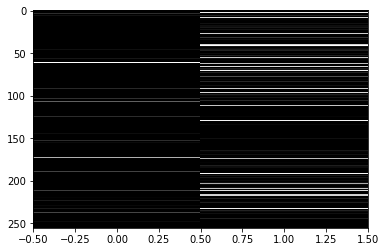

In [120]:
norm_activations = f_activations[0].t() * ((1 / f_activations[0].max(dim=1).values))
plt.imshow(norm_activations.detach().numpy(), aspect='auto', cmap='Greys_r')

In [144]:
g_activations = torch.stack([mid_res[f'identity_gc{i}'].view(-1, 64 * 64 * 256) for i in range(0, 4)], dim=1)

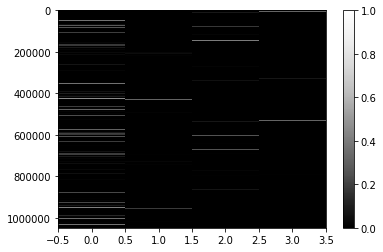

In [145]:
norm_activations_g = g_activations[0].t() * ((1 / g_activations[0].max(dim=1).values))
plt.imshow(norm_activations_g.detach().numpy(), aspect='auto', cmap='Greys_r')
plt.colorbar()

In [146]:
(g_activations[0] == 0).sum(dim=1)

tensor([ 782359,  943729,  982908, 1036209])

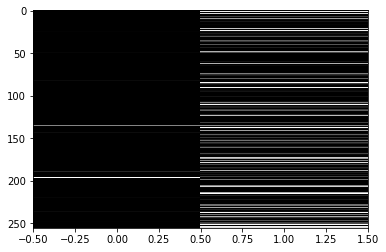

In [121]:
norm_activations2 = f_activations[1].t() * ((1 / f_activations[1].max(dim=1).values))
plt.imshow(norm_activations2.detach().numpy(), aspect='auto', cmap='Greys_r')

In [142]:
(f_activations[1]).sum(dim=1)

tensor([ 25.6496, 102.4687])

In [66]:
loader = DataLoader(selected_datasets_per_qtype['exist'], batch_size=5, shuffle=False, num_workers=0, collate_fn=collate_samples_from_pixels)

In [ ]:
model = RN(args=args, hyp=hyp)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load('best_weights/No_reg_sb_01.pth', map_location='cpu'))
model = model.module

mid_getter = IntermediateLayerGetter(model, return_layers, keep_output=False)

all_res = {}
for qtype in tqdm(qtypes):
    res = make_res_dict()

    loader = DataLoader(selected_datasets_per_qtype[qtype], batch_size=10, shuffle=False, num_workers=0, collate_fn=collate_samples_from_pixels)
    with torch.no_grad():
        model.eval()
        for i, b in tqdm(enumerate(loader), total=len(loader)):
        # for i, b in enumerate(loader):
            model.coord_tensor = None
            mid_res, _ = mid_getter(b['image'], b['question'])

            for k in mha_keys:
                res[k] = torch.cat((res[k], mid_res[k][1].squeeze(1)))

            for k in identity_keys:
                if 'gc' in k:
                    res[k] = torch.cat((res[k], mid_res[k].view(-1, 64, 64, 256)))
                else:
                    res[k] = torch.cat((res[k], mid_res[k]))

            if i == 0:
                break

    all_res[qtype] = res

Supposing original DeepMind model


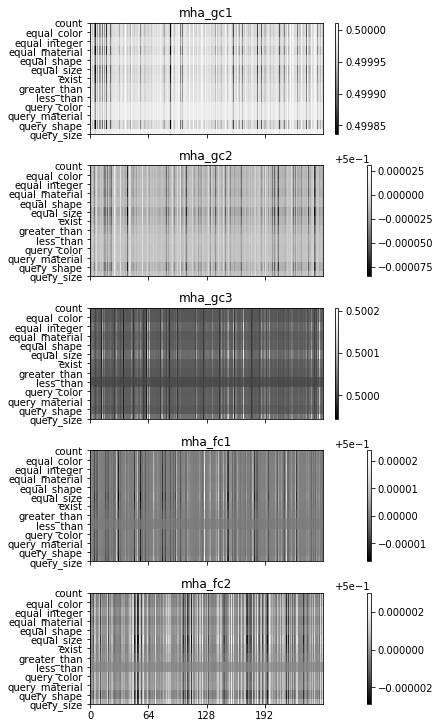

In [260]:
# Reg 0.1 subset 0.1

fig, axes = plt.subplots(ncols=1, nrows=len(mha_keys) - 1, figsize=(6, 10), sharex=True, constrained_layout=True)

norm = colors.LogNorm()
for i, k in enumerate(mha_keys[:-1]):
    ax = axes[i]
    img = ax.imshow(
        np.array([all_res[qtype][k].mean(dim=0).numpy() for qtype in qtypes]),
        aspect='auto',
        cmap='Greys_r',
    )
    ax.set_title(k)
    ax.set_yticks(list(range(len(qtypes))))
    ax.set_yticklabels(qtypes)
    ax.set_xticks([64 * i for i in range(4)])
    cbar = fig.colorbar(img, ax=ax)
    
plt.show()
    

In [ ]:
# No reg subset 0.1

fig, axes = plt.subplots(ncols=1, nrows=len(mha_keys) - 1, figsize=(6, 10), sharex=True, constrained_layout=True)

norm = colors.LogNorm()
for i, k in enumerate(mha_keys[:-1]):
    ax = axes[i]
    img = ax.imshow(
        np.array([all_res[qtype][k].mean(dim=0).numpy() for qtype in qtypes]),
        aspect='auto',
        cmap='Greys_r',
    )
    ax.set_title(k)
    ax.set_yticks(list(range(len(qtypes))))
    ax.set_yticklabels(qtypes)
    ax.set_xticks([64 * i for i in range(4)])
    cbar = fig.colorbar(img, ax=ax)
    
plt.show()
    

In [177]:
from viz_utils import get_all_metrics

In [208]:
identity_keys, mha_keys

(['identity_gc0',
  'identity_gc1',
  'identity_gc2',
  'identity_gc3',
  'identity_fc1',
  'identity_fc2',
  'identity_fc3'],
 ['mha_gc1', 'mha_gc2', 'mha_gc3', 'mha_fc1', 'mha_fc2', 'mha_fc3'])

In [180]:
metrics = get_all_metrics(all_res, identity_keys, mha_keys)

In [236]:
metrics['metrics_per_qtype']['count']['mha_gc1']['histograms_mean']

tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,  67.9000, 187.0000,   1.1000])

In [247]:
n, bins

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000001e-01, 1.07699997e+02,
        1.22300003e+02, 2.58999996e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [252]:
metrics['metrics_per_qtype']['exist']['mha_gc3']['histograms_std']

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.3162, 89.1167,
        72.8835, 17.8997,  0.3162])

<ErrorbarContainer object of 3 artists>

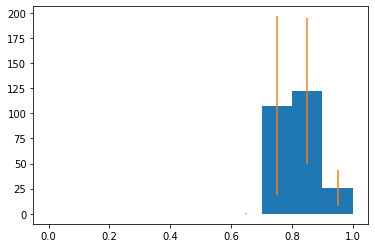

In [251]:
n, bins, _ = plt.hist(
    np.linspace(0, 1, 11), 
    weights=metrics['metrics_per_qtype']['exist']['mha_gc3']['histograms_mean'],
    # yerr=metrics['metrics_per_qtype']['exist']['mha_gc3']['histograms_std'],
)
mid = 0.5 * (bins[1:] + bins[:-1])
plt.errorbar(mid, n, yerr=metrics['metrics_per_qtype']['exist']['mha_gc3']['histograms_std'][:-1], fmt='none')

<BarContainer object of 11 artists>

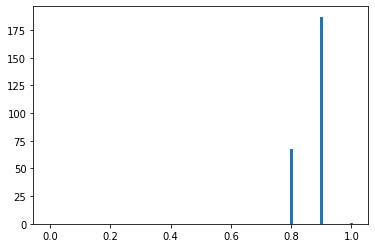

In [239]:
plt.bar(np.linspace(0, 1, 11), metrics['metrics_per_qtype']['count']['mha_gc1']['histograms_mean'], width=0.01)

In [232]:
plmetrics['metrics_per_qtype']['count']['mha_gc1']['histograms_mean']

tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,  67.9000, 187.0000,   1.1000])

In [31]:
from sklearn.manifold import TSNE

In [34]:
all_res['count'].keys()

odict_keys(['identity_gc0', 'mha_gc1', 'identity_gc1', 'mha_gc2', 'identity_gc2', 'mha_gc3', 'identity_gc3', 'mha_fc1', 'identity_fc1', 'mha_fc2', 'identity_fc2', 'mha_fc3', 'identity_fc3'])

In [46]:
X_embedded = TSNE(n_components=2).fit_transform(torch.cat([all_res[qtype]['mha_gc1'] for qtype in qtypes]))

In [36]:
X_embedded

array([[ 153.93373 ,  129.25932 ],
       [ 207.70412 ,  -33.28526 ],
       [ -17.270176,  128.3473  ],
       [ -69.30714 ,  -34.757526],
       [  68.95953 ,   10.983522],
       [  69.73261 , -134.65114 ]], dtype=float32)

In [172]:
torch.cat([all_res[qtype]['mha_gc1'] for qtype in qtypes]).std(dim=0)

torch.Size([256])

In [176]:
print(all_res['count']['mha_gc1'].mean(dim=0))
all_res['exist']['mha_gc1'].mean(dim=0)

tensor([0.8454, 0.8479, 0.8543, 0.8536, 0.8497, 0.8535, 0.8496, 0.8525, 0.8474,
        0.8474, 0.8535, 0.8501, 0.8576, 0.8476, 0.8474, 0.8497, 0.8489, 0.8474,
        0.8486, 0.8488, 0.8470, 0.8522, 0.8486, 0.8482, 0.8473, 0.8484, 0.8481,
        0.8473, 0.8537, 0.8584, 0.8497, 0.8493, 0.8535, 0.8657, 0.8460, 0.8473,
        0.8473, 0.8487, 0.8473, 0.8473, 0.8477, 0.8517, 0.8515, 0.8474, 0.8572,
        0.8505, 0.8473, 0.8476, 0.8584, 0.8512, 0.8497, 0.8473, 0.8494, 0.8494,
        0.8473, 0.8475, 0.8583, 0.8505, 0.8473, 0.8511, 0.8498, 0.8524, 0.8504,
        0.8493, 0.8496, 0.8510, 0.8498, 0.8473, 0.8478, 0.8513, 0.8595, 0.8473,
        0.8473, 0.8474, 0.8487, 0.8534, 0.8474, 0.8504, 0.8503, 0.8473, 0.8515,
        0.8476, 0.8532, 0.8522, 0.8698, 0.8534, 0.8505, 0.8529, 0.8498, 0.8473,
        0.8637, 0.8474, 0.8475, 0.8291, 0.8476, 0.8483, 0.8530, 0.8473, 0.8475,
        0.8533, 0.8497, 0.8476, 0.8492, 0.8581, 0.8540, 0.8473, 0.8901, 0.8473,
        0.8492, 0.8473, 0.8543, 0.8599, 

tensor([0.8618, 0.8642, 0.8705, 0.8699, 0.8660, 0.8698, 0.8659, 0.8687, 0.8637,
        0.8637, 0.8697, 0.8664, 0.8737, 0.8639, 0.8638, 0.8660, 0.8652, 0.8637,
        0.8649, 0.8651, 0.8633, 0.8684, 0.8649, 0.8645, 0.8636, 0.8647, 0.8644,
        0.8637, 0.8699, 0.8746, 0.8660, 0.8656, 0.8698, 0.8817, 0.8624, 0.8636,
        0.8636, 0.8650, 0.8636, 0.8637, 0.8640, 0.8680, 0.8678, 0.8637, 0.8734,
        0.8668, 0.8636, 0.8639, 0.8745, 0.8675, 0.8660, 0.8637, 0.8657, 0.8657,
        0.8636, 0.8638, 0.8745, 0.8668, 0.8636, 0.8674, 0.8660, 0.8686, 0.8667,
        0.8656, 0.8659, 0.8673, 0.8661, 0.8636, 0.8641, 0.8676, 0.8756, 0.8636,
        0.8636, 0.8637, 0.8650, 0.8697, 0.8638, 0.8667, 0.8666, 0.8636, 0.8678,
        0.8639, 0.8694, 0.8685, 0.8857, 0.8696, 0.8667, 0.8691, 0.8661, 0.8636,
        0.8797, 0.8637, 0.8638, 0.8456, 0.8639, 0.8646, 0.8693, 0.8637, 0.8638,
        0.8695, 0.8659, 0.8640, 0.8655, 0.8742, 0.8702, 0.8637, 0.9052, 0.8637,
        0.8655, 0.8636, 0.8706, 0.8761, 

In [171]:
torch.cat([all_res[qtype]['mha_gc1'] for qtype in qtypes]).std(dim=0)

tensor([0.0367, 0.0367, 0.0366, 0.0366, 0.0366, 0.0366, 0.0366, 0.0366, 0.0367,
        0.0367, 0.0366, 0.0366, 0.0365, 0.0367, 0.0367, 0.0366, 0.0367, 0.0367,
        0.0367, 0.0367, 0.0367, 0.0366, 0.0367, 0.0367, 0.0367, 0.0367, 0.0367,
        0.0367, 0.0366, 0.0365, 0.0366, 0.0366, 0.0366, 0.0362, 0.0367, 0.0367,
        0.0367, 0.0367, 0.0367, 0.0367, 0.0367, 0.0366, 0.0366, 0.0367, 0.0365,
        0.0366, 0.0367, 0.0367, 0.0365, 0.0366, 0.0366, 0.0367, 0.0366, 0.0366,
        0.0367, 0.0367, 0.0365, 0.0366, 0.0367, 0.0366, 0.0366, 0.0366, 0.0366,
        0.0366, 0.0366, 0.0366, 0.0366, 0.0367, 0.0367, 0.0366, 0.0364, 0.0367,
        0.0367, 0.0367, 0.0367, 0.0366, 0.0367, 0.0366, 0.0366, 0.0367, 0.0366,
        0.0367, 0.0366, 0.0366, 0.0361, 0.0366, 0.0366, 0.0366, 0.0366, 0.0367,
        0.0363, 0.0367, 0.0367, 0.0367, 0.0367, 0.0367, 0.0366, 0.0367, 0.0367,
        0.0366, 0.0366, 0.0367, 0.0366, 0.0365, 0.0366, 0.0367, 0.0350, 0.0367,
        0.0366, 0.0367, 0.0366, 0.0364, 

In [43]:
all_res['count']['mha_gc1']

tensor([[0.8999, 0.9021, 0.9078,  ..., 0.9085, 0.9048, 0.9088],
        [0.8721, 0.8745, 0.8808,  ..., 0.8815, 0.8774, 0.8818],
        [0.8574, 0.8598, 0.8663,  ..., 0.8671, 0.8628, 0.8674],
        [0.8790, 0.8814, 0.8876,  ..., 0.8883, 0.8843, 0.8886],
        [0.8622, 0.8646, 0.8710,  ..., 0.8718, 0.8676, 0.8721],
        [0.8928, 0.8951, 0.9010,  ..., 0.9017, 0.8978, 0.9020]])

In [56]:
%matplotlib notebook

In [58]:
from matplotlib.cm import get_cmap

tab20 = get_cmap('tab20').colors

<IPython.core.display.Javascript object>


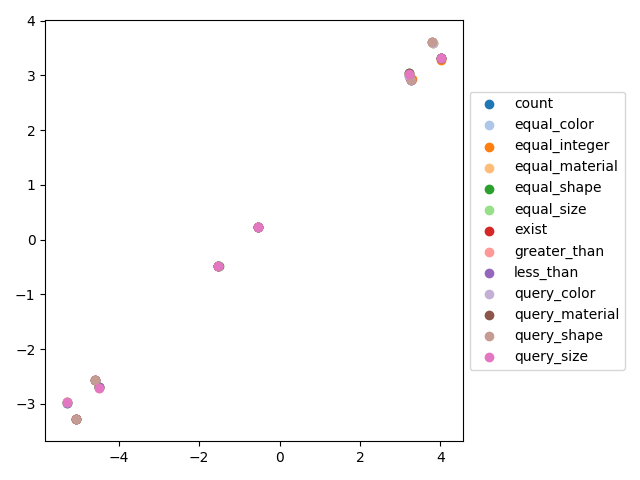

In [65]:
for i, qtype in enumerate(qtypes):
    plt.scatter(
        X_embedded[i * 6:(i + 1) * 6, 0], X_embedded[i * 6:(i + 1) * 6, 1],
        c=[tab20[i]],
        label=qtype,
    )

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [91]:
formatted_res = {}

for qtype, qres in all_res.items():
    mask = torch.empty(0, 256, dtype=torch.float32)
    for k in mha_keys[:-1]:
        mask = torch.cat((mask, qres[k].mean(dim=0).unsqueeze(0)), dim=0)
    formatted_res[qtype] = mask

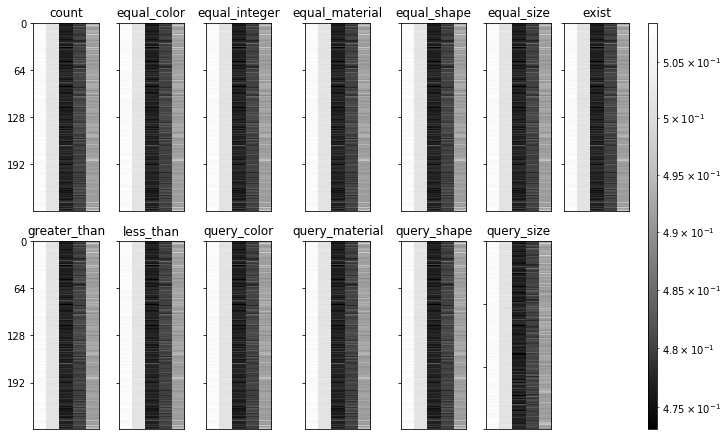

In [92]:
plot_masks(formatted_res)

<IPython.core.display.Javascript object>


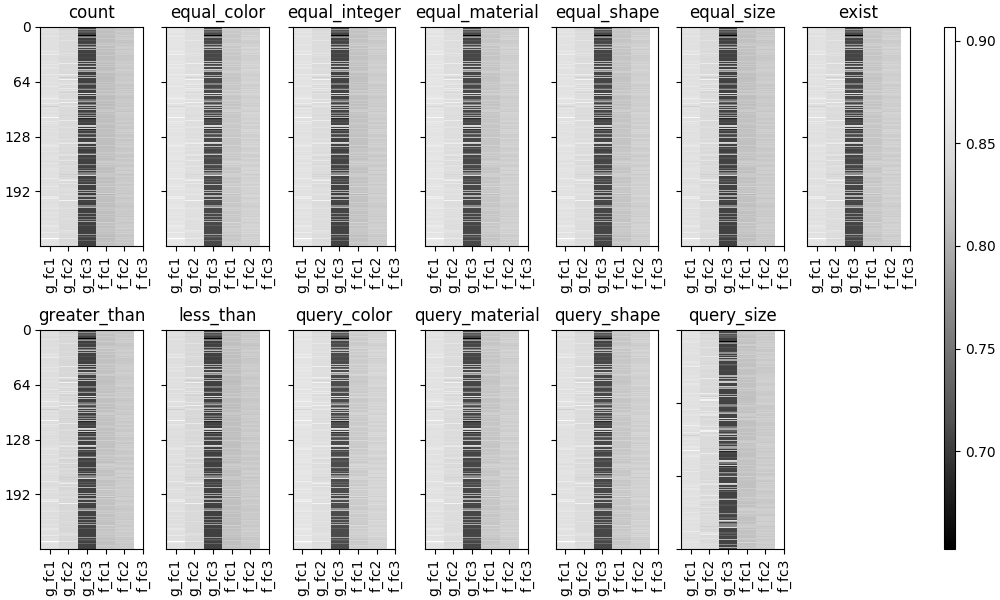

In [96]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(10, 6), sharey=True, constrained_layout=True)

norm = colors.LogNorm()
for i, (qtype, results) in enumerate(all_res.items()):
    ax = axes[i // 7][i % 7]
    img = ax.imshow(
        np.array([stretch_tensor(results[k]).mean(dim=0).numpy() for k in mha_keys[:-1]]).T,
        aspect='auto',
        cmap='Greys_r',
        # norm=norm,
        # vmin=0, vmax=1,
        # vmin=1e-5, vmax=1
    )
    ax.set_title(qtype)
    ax.set_yticks([64 * i for i in range(4)])
    ax.set_xticks(list(range(6)))
    ax.set_xticklabels(['g_fc1', 'g_fc2', 'g_fc3', 'f_fc1', 'f_fc2', 'f_fc3'], rotation='vertical')
    
cax, kw = mpl.colorbar.make_axes([ax for ax in axes.flat[::-1]], aspect=75)
cbar = plt.colorbar(img, cax=cax, aspect=1, **kw)

axes[-1, -1].axis('off')
# plt.tight_layout()
# plt.axis('off')
plt.show()

In [138]:
np.linspace(0, 1, 21)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [165]:
np.histogram(all_res['count']['mha_gc3'].mean(dim=0).numpy(), bins=np.linspace(0, 1, 11))

(array([  0,   0,   0,   0,   0,   0, 153,  85,  18,   0]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [164]:
np.histogram(all_res['count']['mha_gc3'].numpy(), bins=np.linspace(0, 1, 11))

(array([   0,    0,    0,    0,    0,    0,  758, 1548,  254,    0]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [155]:
all_res['count']['mha_gc3'].size()

torch.Size([10, 256])

In [166]:
torch.histc(all_res['count']['mha_gc3'].mean(dim=0), min=0, max=1, bins=11)

tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0., 184.,  64.,   8.,   0.])

In [167]:
torch.stack([torch.histc(t , min=0, max=1, bins=11) for t in all_res['count']['mha_gc3']]).mean(dim=0)

tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.4000,
        164.9000,  76.0000,  14.7000,   0.0000])

In [168]:
torch.stack([torch.histc(t , min=0, max=1, bins=11) for t in all_res['count']['mha_gc3']]).std(dim=0)

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.5164, 59.7224,
        48.5478, 14.5530,  0.0000])

(array([  0.,   0.,   0.,   0.,   0.,   0., 153.,  85.,  18.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

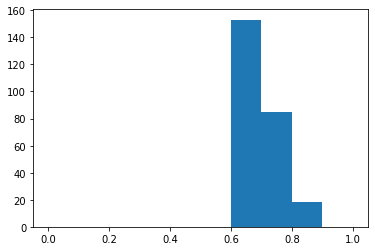

In [231]:
plt.hist(all_res['count']['mha_gc3'].mean(dim=0).numpy(), bins=np.linspace(0, 1, 11))

In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
import json
import pickle

import torch

import numpy as np

from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt

from attrdict import AttrDict

from model import RN
from viz_utils import init_selected_datasets, load_model, compute_mid_results, get_all_metrics, mha_keys, identity_keys, plot_masks_per_qtype


device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'

In [3]:
selected_ds_per_qtype, dictionaries = init_selected_datasets(
    '/mnt/nas2/GrimaRepo/datasets/CLEVR_v1.0',
    '/home/fcorencoret/RelationNetworks-CLEVR/questions/CLEVR_built_dictionaries.pkl',
    'viz/selected_idxs_per_qtype.json',
)

with open('config.json', 'r') as f:
    hyp = json.load(f)['hyperparams']['original-fp']
    
qtypes = list(selected_ds_per_qtype.keys())

args = AttrDict()
args.qdict_size = len(dictionaries[0])
args.adict_size = len(dictionaries[1])

==> using cached questions: questions/CLEVR_val_questions.pkl


In [45]:
model = load_model(
    RN(args, hyp),
    '/home/fcorencoret/RelationNetworks-CLEVR/resume_training/best_weights.pth',
    [device],
)

Supposing original DeepMind model


In [46]:
res = compute_mid_results(
    model,
    selected_ds_per_qtype,
    bsz=128,
    device=device,
    samples_per_qtype=256,
    with_identity=False,
)

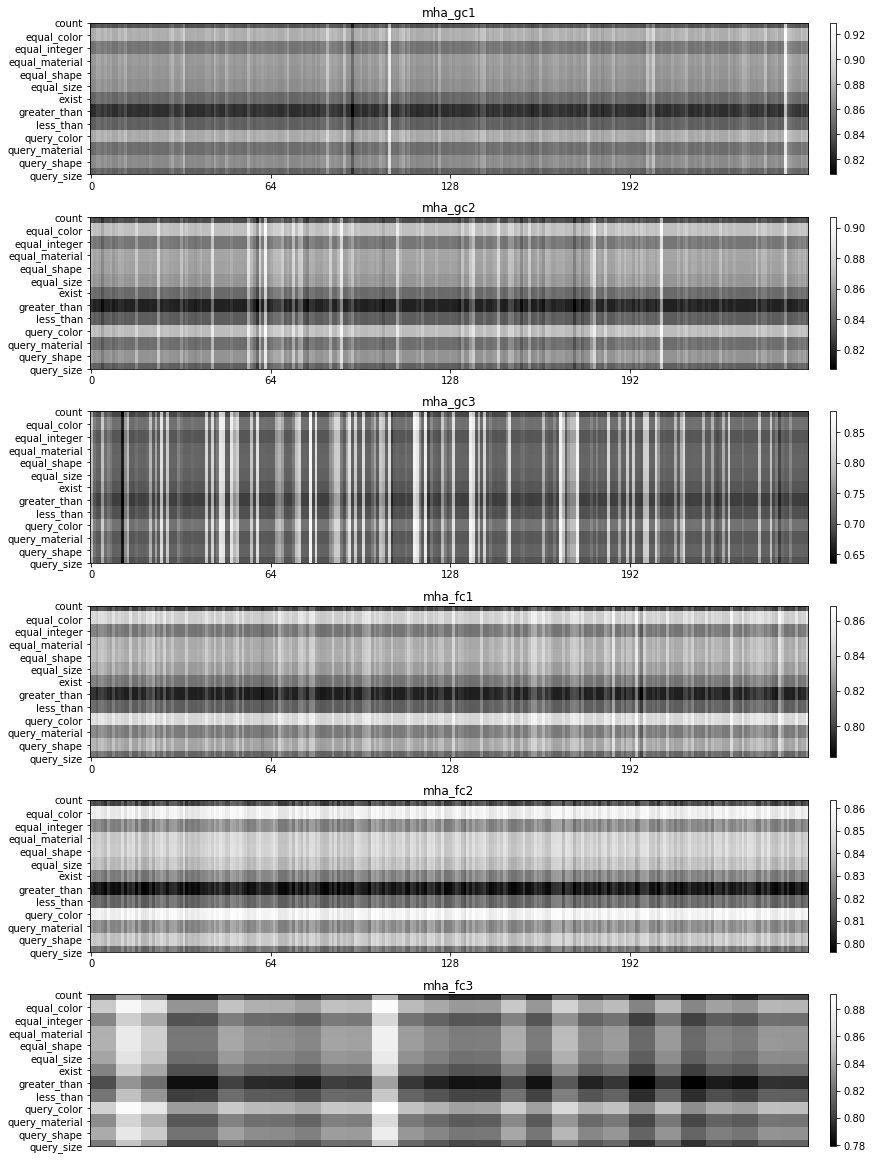

In [47]:
plot_masks_per_qtype(res)

In [48]:
metrics = get_all_metrics(res)

In [56]:
metrics['metrics_per_qtype']['count']['mha_gc1']['histograms_mean'], metrics['metrics_per_qtype']['count']['mha_gc1']['histograms_std']

(tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           2.8555,  66.4062, 185.7852,   0.9531]),
 tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          26.2968, 108.1159, 109.2636,   1.7121]))

In [64]:
torch.histc(torch.empty(1, 256).uniform_(0, 1), min=0, max=1, bins=11)

tensor([33., 18., 24., 17., 21., 21., 24., 33., 18., 23., 24.])

In [69]:
np.histogram(np.random.uniform(0, 1, size=(256)), bins=np.linspace(0, 1, 11))

(array([30, 27, 18, 27, 27, 30, 26, 25, 20, 26]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [ ]:
np